## Intro

This is the product of a class competition to predict hourly bike share rentals in DC for 2012 and 2013. The data provided had a test set we were supposed to predict on that contained the 20th to final day of each month and a training set that contained the remainder. In order to model this problem I used xgBoost. The results were scored using root mean logarithmic square error, $\sqrt{N^-1\sum_i^N (\log(\hat m_i) - \log(m_i))^2}$. This meant creating a custom evaluation function for xgBoost. Also, given the time series nature of the problem, I created a custom cross validation function

## Start 

In [10]:
import pandas as pd
import numpy as np
# xgboost
import xgboost as xgb

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [11]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [12]:
train.head()

,daylabel,year,month,day,hour,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
0,1,2011,1,1,0,1,0,0,1.0,9.84,14.395,81.0,0.0,16
1,1,2011,1,1,1,1,0,0,1.0,9.02,13.635,80.0,0.0,40
2,1,2011,1,1,2,1,0,0,1.0,9.02,13.635,80.0,0.0,32
3,1,2011,1,1,3,1,0,0,1.0,9.84,14.395,75.0,0.0,13
4,1,2011,1,1,4,1,0,0,1.0,9.84,14.395,75.0,0.0,1


## Date Cleaning

In [13]:
def add_time(train):
    
    train["date"] = train["month"].astype(str) + "/" \
                         + train["day"].astype(str) + "/" \
                         + train["year"].astype(str) + "/" \
                         + train["hour"].astype(str).str.zfill(2)
    train["date"] = pd.to_datetime(train["date"], format="%m/%d/%Y/%H")
    train["dayOfWeek"] = train["date"].dt.dayofweek
    return train

In [14]:
def cleanAll(all_data):
    # Get dummies and split data
    wTime = add_time(all_data)
    _data = pd.get_dummies(wTime, columns=["year", "month", "hour", "season", "weather", "dayOfWeek"]) 
    test = _data[_data["day"] > 19]
    train = _data[_data["day"] < 20]

    # Splits target vars
    y_train = train["count"]
    X_train = train.drop(["count", "date"], axis=1)
    X_test = test.drop(["date", "count"], axis=1)
    
    return X_train, y_train, X_test

In [15]:
all_data = pd.concat([train, test], axis=0)
all_data_sorted = all_data.set_index(["daylabel", "hour"]).sort_index().reset_index()

In [16]:
X, y, X_test = cleanAll(all_data_sorted)

## XGBoost Fitting

#### RMSLE for XGBoost

In [22]:
def rmsle_eval(y, y0):
    y0=y0.get_label()
    y[y < 0] = 0
    assert len(y) == len(y0)
    return 'error', np.sqrt(np.mean(np.square(np.log(y + 1) - np.log(y0 + 1))))

### Custom Cross Validation

#### Custom Cross Splitter

In [19]:
def custom_cv(data):
    cvs = []
    for i in range(5):
        lower = 1 + (i * 4)
        upper = lower + 3
        trainIndices = data[(data["day"] < lower)  | (data["day"] > upper) ].index.values.astype(int)
        testIndices = data[(data["day"] >= lower) & (data["day"] <= upper)].index.values.astype(int)
        cvs.append((trainIndices, testIndices))
    return cvs

In [20]:
custom_cv(data=X)

[(array([   96,    97,    98, ..., 17136, 17137, 17138]),
  array([    0,     1,     2, ..., 16776, 16777, 16778])),
 (array([    0,     1,     2, ..., 17136, 17137, 17138]),
  array([   96,    97,    98, ..., 16872, 16873, 16874])),
 (array([    0,     1,     2, ..., 17136, 17137, 17138]),
  array([  192,   193,   194, ..., 16968, 16969, 16970])),
 (array([    0,     1,     2, ..., 17136, 17137, 17138]),
  array([  288,   289,   290, ..., 17064, 17065, 17066])),
 (array([    0,     1,     2, ..., 17064, 17065, 17066]),
  array([  384,   385,   386, ..., 17136, 17137, 17138]))]

#### Custom XBG CV function with validation score minimization

In [69]:
def cv_xgb(X, y, cv_splits, params):
    
    plst = list(params.items())
    storage = np.array([])
    
    # Iteratve over each cv split
    for i in range(len(cv_splits)):
        
        # Get train and test (validation) datasets
        train_indices = cv_splits[i][0] # Indices
        X_train= X.ix[train_indices]
        y_train = y[train_indices]
        
        test_indices = cv_splits[i][1]  # Indices
        X_test = X.ix[test_indices, :]
        y_test = y[test_indices]
        
        # Create the data objects
        xgbTrain = xgb.DMatrix(X_train, label=y_train)
        xgbVal = xgb.DMatrix(X_test, label=y_test)

        # define a watch list to observe the change in error f your training and holdout data
        watchlist  = [(xgbTrain,'train'),(xgbVal,'eval')]
        
        # The model
        model = xgb.train(plst, 
                          xgbTrain,
                          300,
                          evals=watchlist,
                          verbose_eval=False,
                          feval=rmsle_eval,
                          early_stopping_rounds=70)   # stops 50 iterations after marginal improvements or drop in performance on your hold out set
        # Predict the test on the data
        pred_train=model.predict(xgbVal)

        res = rmsle_eval(pred_train, xgbVal)[1] 
        storage = np.append(storage, res)
    
    mean_cv = storage.mean()
    return mean_cv

## Tune Parameters

In [70]:
def grid_search_depth_and_leafsize(X, y, cv_splits):
    
    params = {}
    params["objective"] = "reg:linear"
    params["eta"] = 0.1
    params["subsample"] = 0.8
    params["colsample_bytree"] = 0.8
    params["scale_pos_weight"] = 1.0
    params["silent"] = 1
    params["n_estimators"] = 300

    results = {}
    
    leaf_size = [2]
    search_depths = [10]
    for size in leaf_size:
        params["min_child_weight"] = size
        for depth in search_depths:
            params["max_depth"] = depth
            results[("Child_Weight", size, "Max Depth", depth)] = cv_xgb(X, y, cv_splits, params)
    print results
    print "\nBest Result"
    best = min(results, key=results.get)
    print best, results[best]

#### Leaf and Depth Results:
* leaf_size = range(0,12,2), search_depths = range(9,16, 3)
        ('Child_Weight', 2, 'Max Depth', 10) 0.543826654553
* leaf_size = [1,2,3], search_depths = [9,10,11]
        ('Child_Weight', 2, 'Max Depth', 11) 0.543428257108
* leaf_size = [1,2,3], search_depths = [9, 10,11,12,13]
        ('Child_Weight', 2, 'Max Depth', 10) 0.543178677559

In [71]:
splits = custom_cv(X)
grid_search_depth_and_leafsize(X, y, splits)

{('Child_Weight', 2, 'Max Depth', 10): 0.54725423455238342}

Best Result
('Child_Weight', 2, 'Max Depth', 10) 0.547254234552


In [229]:
def grid_search_gamma(X, y, cv_splits):
    
    params = {}
    params["objective"] = "reg:linear"
    params["eta"] = 0.1
    params["subsample"] = 0.8
    params["colsample_bytree"] = 0.8
    params["scale_pos_weight"] = 1.0
    params["silent"] = 1
    params["min_child_weight"] = 2 # Set previously
    params["max_depth"] = 10  # Set previously
    params["n_estimators"] = 300
    
    results = {}
    gammas = [.218, .219, .22, .221, .222]
    for gamma in gammas:
        params["gamma"] = gamma
        results[("Gamma", gamma)]= cv_xgb(X, y, cv_splits, params)
    print results
    print "\nBest Result"
    best = min(results, key=results.get)
    print best, results[best]

#### Gamma Results

* [.0, .1, .2, .3, .4]
        ('Gamma', 0.2) 0.541293352842
* [.16, .18, .2, .22, .24]
        ('Gamma', 0.22) 0.538993373513
* [.218, .219, .22, .221, .222]
        ('Gamma', 0.222) 0.538165062666

In [227]:
splits = custom_cv(X)
grid_search_gamma(X, y, splits)

{('Gamma', 0.219): 0.53899337351322174, ('Gamma', 0.22): 0.53899337351322174, ('Gamma', 0.222): 0.53816506266593933, ('Gamma', 0.221): 0.53899435698986053, ('Gamma', 0.218): 0.53950835764408112}

Best Result
('Gamma', 0.222) 0.538165062666


In [244]:
def grid_search_col_and_sample(X, y, cv_splits):
    
    params = {}
    params["objective"] = "reg:linear"
    params["eta"] = 0.1
    params["silent"] = 1
    params["min_child_weight"] = 2 # Set previously
    params["max_depth"] = 10  # Set previously
    params["gamma"] = 0.222 # Set previously
    params["n_estimators"] = 300

    results = {}
    
    sub_samples = [1]
    col_samples = [0.525, .530, 0.535, 0.54]
    for sub in sub_samples:
        params["subsample"] = sub
        for cols in col_samples:
            params["colsample_bytree"] = cols
            results[("sub Sample", sub, "Col Sample", cols)] = cv_xgb(X, y, cv_splits, params)
    print results
    print "\nBest Result"
    best = min(results, key=results.get)
    print best, results[best]

#### Col and Sample Size

* sub_samples = [i/10.0 for i in range(5,11)] col_samples = [i/10.0 for i in range(5,11)]
        ('sub Sample', 1.0, 'Col Sample', 0.5) 0.523538246751
* sub = [0.95, 1] col = [0.15, 0.3, 0.4, 0.45]
        ('sub Sample', 1, 'Col Sample', 0.45) 0.568363755941
* sub = [1] col_samples = [0.45, 0.5, 0.55]
        ('sub Sample', 1, 'Col Sample', 0.55) 0.518855884671
* sub = [1] col_samples = [ 0.535, 0.55, 0.58, 0.575]
        ('sub Sample', 1, 'Col Sample', 0.535) 0.516191244125

In [245]:
splits = custom_cv(X)
grid_search_col_and_sample(X, y, splits)

{('sub Sample', 1, 'Col Sample', 0.525): 0.51619124412536621, ('sub Sample', 1, 'Col Sample', 0.54): 0.51885588467121124, ('sub Sample', 1, 'Col Sample', 0.535): 0.51619124412536621, ('sub Sample', 1, 'Col Sample', 0.53): 0.51619124412536621}

Best Result
('sub Sample', 1, 'Col Sample', 0.525) 0.516191244125


In [254]:
def grid_search_alpha(X, y, cv_splits):
    
    params = {}
    params["objective"] = "reg:linear"
    params["eta"] = 0.1
    params["silent"] = 1
    params["min_child_weight"] = 2 # Set previously
    params["max_depth"] = 10  # Set previously
    params["gamma"] = 0.222 # Set previously
    params["subsample"] = 1.0  # Set previously
    params["colsample_bytree"] = 0.525   # Set previously
    params["n_estimators"] = 300
    
    alphas = [.95, 1, 1.05]
    results = {}
    for alpha in alphas:
        params["reg_alpha"] = alpha
        results[("Alpha", alpha)]= cv_xgb(X, y, cv_splits, params)
    
    print results
    print "\nBest Result"
    best = min(results, key=results.get)
    print best, results[best]

#### Alpha Search

* alphas = [1e-5, 1e-2, 0.1, 1, 100]
        ('Alpha', 1) 0.509460173547

In [255]:
splits = custom_cv(X)
grid_search_alpha(X, y, splits)

{('Alpha', 1.05): 0.52325518429279327, ('Alpha', 0.95): 0.51715943217277527, ('Alpha', 1): 0.51058875769376755}

Best Result
('Alpha', 1) 0.510588757694


In [266]:
def grid_search_learning_rate(X, y, cv_splits):
    
    params = {}
    params["objective"] = "reg:linear"
    params["eta"] = 0.1
    params["silent"] = 1
    params["min_child_weight"] = 2 # Set previously
    params["max_depth"] = 10  # Set previously
    params["gamma"] = 0.222 # Set previously
    params["subsample"] = 1.0  # Set previously
    params["colsample_bytree"] = 0.525   # Set previously
    params["reg_alpha"] = 1 # Set Previously
    
    estimators = [325, 350]
    learn_rates = [0.05]
    results = {}
    for est in estimators:
        params["n_estimators"] = est
        for lrn in learn_rates:
            params["learning_rate"] = lrn
            results[("Lrn Rate", lrn, "N_ests", est)]= cv_xgb(X, y, cv_splits, params)
    
    print results
    print "\nBest Result"
    best = min(results, key=results.get)
    print best, results[best]

('Lrn Rate', 0.05, 'N_ests', 400) 0.496107257903

('Lrn Rate', 0.05, 'N_ests', 350) 0.496107257903

In [268]:
splits = custom_cv(X)
grid_search_learning_rate(X, y, splits)

{('Lrn Rate', 0.05, 'N_ests', 350): 0.49610725790262222, ('Lrn Rate', 0.05, 'N_ests', 450): 0.49610725790262222, ('Lrn Rate', 0.05, 'N_ests', 400): 0.49610725790262222}

Best Result
('Lrn Rate', 0.05, 'N_ests', 350) 0.496107257903


## Predict Values

In [26]:
def finished_model(X, y, test, cv_splits):
    
    params = {}
    params["objective"] = "reg:linear"
    params["eta"] = 0.1
    params["silent"] = 1
    params["min_child_weight"] = 2 # Set previously
    params["max_depth"] = 10  # Set previously
    params["gamma"] = 0.222 # Set previously
    params["subsample"] = 1.0  # Set previously
    params["colsample_bytree"] = 0.525  # Set previously
    params["reg_alpha"] = 1  # Set Previously
    params["n_estimators"] = 350  # Set Previously
    params["learning_rate"] = 0.05  # Set Previously
    
    plst = list(params.items())
    predictions = np.empty((len(test),5))
    storage = np.array([])
    # Iteratve over each 
    for i in range(len(cv_splits)):
        
        # Get train and test (validation) datasets
        train_indices = cv_splits[i][0] # Indices
        X_train= X.ix[train_indices]
        y_train = y[train_indices]
        
        test_indices = cv_splits[i][1]  # Indices
        X_test = X.ix[test_indices, :]
        y_test = y[test_indices]
        
        # Create the data objects
        xgbTrain = xgb.DMatrix(X_train, label=y_train)
        xgbVal = xgb.DMatrix(X_test, label=y_test)
        xgbTest = xgb.DMatrix(test)

        # define a watch list to observe the change in error f your training and holdout data
        watchlist  = [(xgbTrain,'train'),(xgbVal,'eval')]
        
        # The model
        model = xgb.train(plst, 
                          xgbTrain,
                          400,
                          evals=watchlist,
                          verbose_eval=True,
                          feval=rmsle_eval,
                          early_stopping_rounds=70)
        # Predict the test on the data
        pred_train=model.predict(xgbVal)
        res = rmsle_eval(pred_train, xgbVal)[1]
        storage = np.append(storage, res)
        # Make prediction on model
        pred_test = model.predict(xgbTest)
        predictions[:,i] = pred_test
    
    # Average accross predictions
    final_prediction = predictions.mean(axis=1)
    final_prediction[final_prediction < 0] = 0
    
    return final_prediction, predictions, storage

In [27]:
splits = custom_cv(X)
# final, results = finished_model
final_prediction, predictions, storage = finished_model(X, y, X_test, splits)

[0]	train-error:2.62822	eval-error:2.64033
Multiple eval metrics have been passed: 'eval-error' will be used for early stopping.

Will train until eval-error hasn't improved in 70 rounds.
[1]	train-error:2.077	eval-error:2.08466
[2]	train-error:1.75756	eval-error:1.77815
[3]	train-error:1.54716	eval-error:1.5675
[4]	train-error:1.36961	eval-error:1.39857
[5]	train-error:1.25586	eval-error:1.27773
[6]	train-error:1.17342	eval-error:1.19886
[7]	train-error:1.10846	eval-error:1.14229
[8]	train-error:1.0557	eval-error:1.08988
[9]	train-error:1.00726	eval-error:1.04086
[10]	train-error:0.96334	eval-error:0.999404
[11]	train-error:0.911116	eval-error:0.948764
[12]	train-error:0.887546	eval-error:0.926135
[13]	train-error:0.871751	eval-error:0.910196
[14]	train-error:0.84745	eval-error:0.887706
[15]	train-error:0.841308	eval-error:0.882626
[16]	train-error:0.845598	eval-error:0.885233
[17]	train-error:0.835762	eval-error:0.878256
[18]	train-error:0.825376	eval-error:0.871296
[19]	train-error:

In [30]:
final_prediction

array([  10.11132298,    4.09915237,    5.68410316, ...,  143.17709961,
         93.77614441,   54.65642776])

In [32]:
np.savetxt("assn1-garethjones.txt",final_prediction, fmt='%.18f')

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

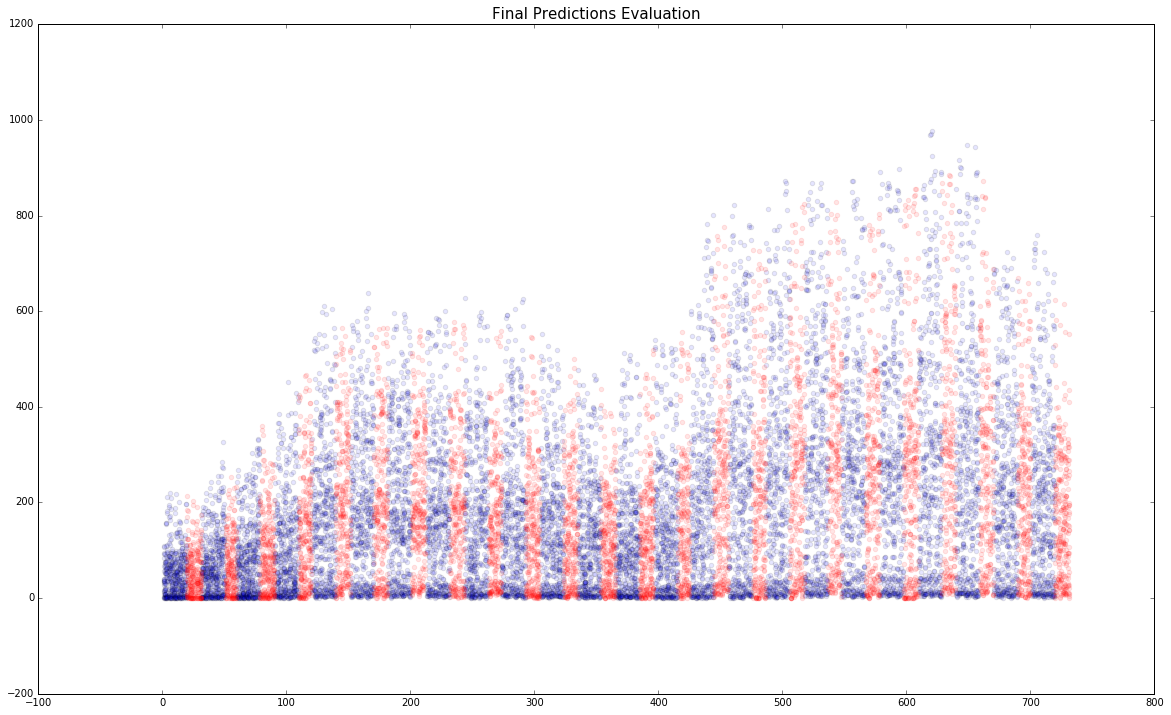

In [31]:
plt.figure(figsize=(20, 12))
plt.scatter(X["daylabel"], y, alpha = 0.1)
plt.scatter(X_test["daylabel"], final_prediction, alpha=0.1, color="r")
plt.title("Final Predictions Evaluation", fontsize=15)